In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

sys.path.append(os.path.join(os.getcwd(), '..'))
from dataset_utils.dataset import StudioLiveDataset, StudioLiveDataModule

/home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
STUDIO_PATH = "../../dataset/studio"
LIVE_PATH = "../../dataset/live"

In [3]:
dataset = StudioLiveDataset(
    studio_dir=STUDIO_PATH,
    live_dir=LIVE_PATH,
    sr=22050,
    segment_duration=4.0,  # 4 second segments
    development_mode=False, 
    max_offset_sec=100.0
)

print(f"Dataset loaded with {len(dataset)} segments")

Loading Whisper model for lyric alignment...
Finding and aligning 25 pairs...


Processing pairs:   0%|          | 0/25 [00:00<?, ?it/s]


Processing pairs:   4%|▍         | 1/25 [00:03<01:34,  3.94s/it, Blinding Lights.mp3... → offset=-50.7s, corr=0.281, 50 segments of 4.0s]

Processing pairs:  16%|█▌        | 4/25 [00:14<01:17,  3.71s/it, Crew Love.mp3... → offset=0.1s, corr=0.099, 28 segments of 4.0s]         

  0%|          | 0/36192 [00:00<?, ?frames/s]


100%|██████████| 26025/26025 [00:06<00:00, 3726.67frames/s]s/it, After Hours.mp3... → offset=10.7s, corr=0.374, 66 segments of 4.0s]

Processing pairs:  28%|██▊       | 7/25 [00:29<01:17,  4.31s/it, Die For You.mp3... → offset=-7.3s, corr=0.017, 46 segments of 4.0s]

 97%|█████████▋| 20600/21159 [00:09<00:00, 2193.31frames/s]



Processing pairs:  36%|███▌      | 9/25 [00:41<01:18,  4.92s/it, Gasoline.mp3... → offset=31.2s, corr=0.013, 45 segments of 4.0s]       


 12%|█▏        | 5600/45533 [00:01<00:13, 2972.40frames/s]

Processing pairs:  44%|████▍     | 11/25 [00:46<00:55,  3.94s/it, Kiss Land.mp3... → offset=88.8s, corr=0.026, 27 segments of 4.0s]







Processing pairs:  48%|████▊     | 12/25 [00:50<00:53,  4.14s/it, How Do I Make You Lo... → offset=-13.5s, corr=0.016, 48 segments of 4.0s]


Processing pairs:  52%|█████▏    | 13/25 [00:53<00:44,  3.69s/it, I Feel It Coming.mp3... → offset=93.1s, corr=0.012, 44 segments of 4.0s] 


Processing pairs:  56%|█████▌    | 14/25 [00:57<00:42,  3.83s/it, Low Life.mp3... → offset=7.7s, corr=0.021, 26 segments of 4.0s]         


Processing pairs:  60%|██████    | 15/25 [01:02<00:41,  4.13s/it, Is There Someone Els... → offset=-26.3s, corr=0.020, 49 segments of 4.0s]








  0%|          | 0/24909 [00:00<?, ?frames/s]

100%|██████████| 21192/21192 [00:03<00:00, 5401.77frames/s]0s/it, Often.mp3... → offset=84.4s, corr=0.037, 37 segments of 4.0s]            


Processing pairs:  72%|███████▏  | 18/25 [01:19<00:37,  5.38s/it, Out Of Time.mp3... → offset=0.0s, corr=0.015, 50 segments of 4.0s]    


Processing pairs:  80%|████████  | 20/25 [01:25<00:21,  4.28s/it, Sacrifice.mp3... → offset=-80.2s, corr=0.013, 45 segments of 4.0s]


Processing pairs:  84%|████████▍ | 21/25 [01:27<00:15,  3.78s/it, Starboy.mp3... → offset=3.1s, corr=0.027, 56 segments of 4.0s]          

Processing pairs:  96%|█████████▌| 24/25 [01:39<00:03,  3.66s/it, The Hills.mp3... → offset=61.8s, corr=0.216, 45 segments of 4.0s]   










Processing pairs: 100%|██████████| 25/25 [02:09<00:00,  5.19s/it, Take My Breath.mp3... → offset=16.9s, corr=0.020, 5 segments of 4.0s]


Total segments: 968
Dataset loaded with 968 segments


## Visualize segments

In [ ]:
correlations = []
durations = []
pairs_info = []

for i in range(len(dataset)):
    info = dataset.get_pair_info(i)
    correlations.append(info['correlation'])
    durations.append(info['duration'])
    pairs_info.append(info)

print(f"Correlation stats:")
print(f"  Mean: {np.mean(correlations):.3f}")
print(f"  Min: {np.min(correlations):.3f}")
print(f"  Max: {np.max(correlations):.3f}")
print(f"  Std: {np.std(correlations):.3f}")

print(f"\nDuration stats:")
print(f"  Mean: {np.mean(durations):.2f}s")
print(f"  Min: {np.min(durations):.2f}s")
print(f"  Max: {np.max(durations):.2f}s")

Correlation stats:
  Mean: 0.144
  Min: 0.007
  Max: 0.694
  Std: 0.134

Duration stats:
  Mean: 4.00s
  Min: 4.00s
  Max: 4.00s


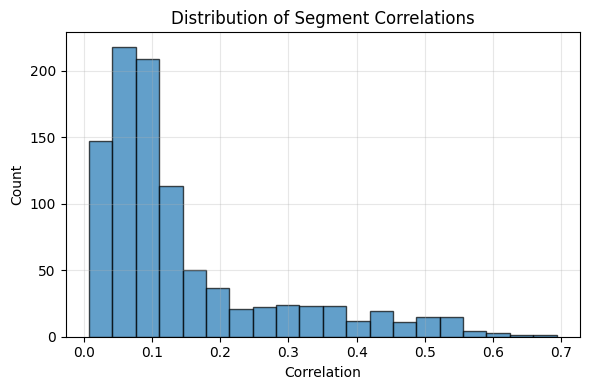

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))

ax1.hist(correlations, bins=20, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Segment Correlations')
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Visualize Best and Worst Alignments

In [ ]:
best_idx = np.argmax(correlations)
worst_idx = np.argmin(correlations)

print(f"Best correlation: {correlations[best_idx]:.3f} (segment {best_idx})")
print(f"Worst correlation: {correlations[worst_idx]:.3f} (segment {worst_idx})")

best_x, best_y = dataset[best_idx]
worst_x, worst_y = dataset[worst_idx]

best_info = dataset.get_pair_info(best_idx)
worst_info = dataset.get_pair_info(worst_idx)

Best correlation: 0.694 (segment 618)
Worst correlation: 0.007 (segment 517)


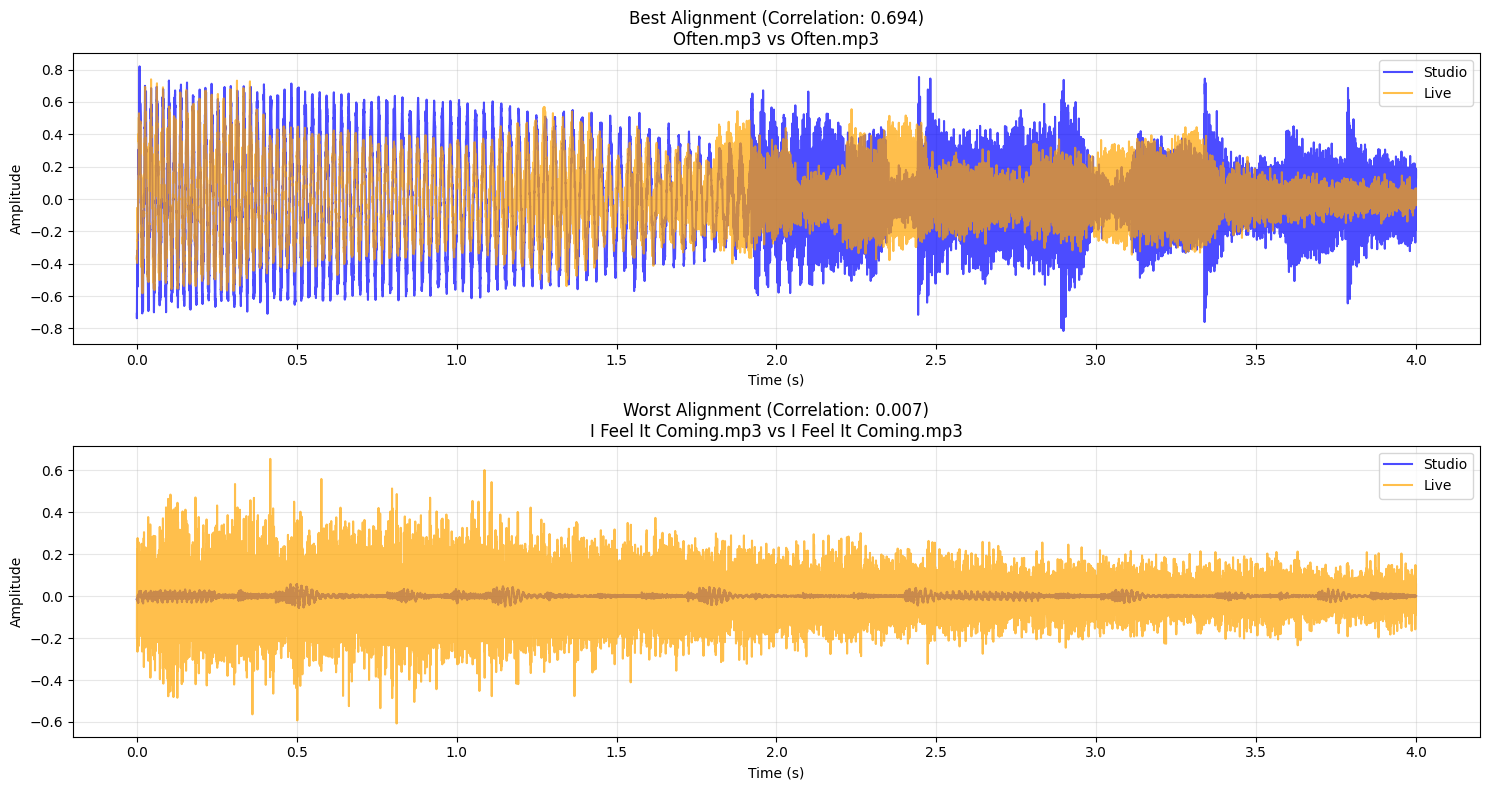

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

sr = 22050
time_best = np.arange(len(best_x)) / sr
time_worst = np.arange(len(worst_x)) / sr

# best alignment
axes[0].plot(time_best, best_x.numpy(), alpha=0.7, label='Studio', color='blue')
axes[0].plot(time_best, best_y.numpy(), alpha=0.7, label='Live', color='orange')
axes[0].set_title(f"Best Alignment (Correlation: {best_info['correlation']:.3f})\n{best_info['studio_name']} vs {best_info['live_name']}")
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# worst alignment
axes[1].plot(time_worst, worst_x.numpy(), alpha=0.7, label='Studio', color='blue')
axes[1].plot(time_worst, worst_y.numpy(), alpha=0.7, label='Live', color='orange')
axes[1].set_title(f"Worst Alignment (Correlation: {worst_info['correlation']:.3f})\n{worst_info['studio_name']} vs {worst_info['live_name']}")
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Listen to Audio Segments

In [8]:
print("Best alignment:")
print(f"Studio ({best_info['studio_name']})")
display(Audio(best_x.numpy(), rate=sr))

print(f"\nLive ({best_info['live_name']})")
display(Audio(best_y.numpy(), rate=sr))


print("Worst alignment:")
print(f"Studio ({worst_info['studio_name']})")
display(Audio(worst_x.numpy(), rate=sr))    

print(f"\nLive ({worst_info['live_name']})")
display(Audio(worst_y.numpy(), rate=sr))

Best alignment:
Studio (Often.mp3)



Live (Often.mp3)


Worst alignment:
Studio (I Feel It Coming.mp3)



Live (I Feel It Coming.mp3)


## Analyze Unique Pairs

In [9]:
unique_pairs = {}
for i, info in enumerate(pairs_info):
    pair_key = (info['studio_name'], info['live_name'])
    if pair_key not in unique_pairs:
        unique_pairs[pair_key] = []
    unique_pairs[pair_key].append((i, info))

print(f"Unique studio-live pairs: {len(unique_pairs)}")
for pair_key, segments in unique_pairs.items():
    studio_name, live_name = pair_key
    avg_corr = np.mean([seg[1]['correlation'] for seg in segments])
    offset_sec = segments[0][1]['offset_sec']  
    print(f"  {studio_name} <-> {live_name}: {len(segments)} segments, avg corr={avg_corr:.3f}, offset={offset_sec:.2f}s")

Unique studio-live pairs: 25
  Blinding Lights.mp3 <-> Blinding Lights.mp3: 50 segments, avg corr=0.298, offset=-50.66s
  Alone Again.mp3 <-> Alone Again.mp3: 39 segments, avg corr=0.082, offset=94.20s
  Can't Feel My Face.mp3 <-> Can't Feel My Face.mp3: 42 segments, avg corr=0.070, offset=-12.92s
  Crew Love.mp3 <-> Crew Love.mp3: 28 segments, avg corr=0.138, offset=0.07s
  Faith.mp3 <-> Faith.mp3: 19 segments, avg corr=0.153, offset=-2.19s
  After Hours.mp3 <-> After Hours.mp3: 66 segments, avg corr=0.153, offset=10.66s
  Heartless.mp3 <-> Heartless.mp3: 31 segments, avg corr=0.365, offset=0.48s
  Die For You.mp3 <-> Die For You.mp3: 46 segments, avg corr=0.093, offset=-7.31s
  I Was Never There.mp3 <-> I Was Never There.mp3: 34 segments, avg corr=0.413, offset=0.00s
  Gasoline.mp3 <-> Gasoline.mp3: 45 segments, avg corr=0.099, offset=31.21s
  Kiss Land.mp3 <-> Kiss Land.mp3: 27 segments, avg corr=0.121, offset=88.78s
  How Do I Make You Love Me.mp3 <-> How Do I Make You Love Me.mp3:

## Test DataModule

In [10]:
dm = StudioLiveDataModule(
    studio_dir=STUDIO_PATH,
    live_dir=LIVE_PATH,
    batch_size=4,
    segment_duration=4.0,
    development_mode=False
)

dm.setup()

print(f"Train dataset size: {len(dm.train_dataset)}")
print(f"Validation dataset size: {len(dm.val_dataset)}")

Loading Whisper model for lyric alignment...
Finding and aligning 25 pairs...


Processing pairs:   0%|          | 0/25 [00:00<?, ?it/s]





Processing pairs:   4%|▍         | 1/25 [00:03<01:14,  3.12s/it, Can't Feel My Face.m... → offset=-12.9s, corr=0.015, 42 segments of 4.0s]













100%|██████████| 20320/20320 [00:03<00:00, 6099.49frames/s]

 88%|████████▊ | 22336/25336 [00:06<00:00, 3310.27frames/s]s/it, Crew Love.mp3... → offset=0.1s, corr=0.099, 28 segments of 4.0s]         


Processing pairs:  20%|██        | 5/25 [00:21<01:34,  4.71s/it, Die For You.mp3... → offset=-7.3s, corr=0.017, 46 segments of 4.0s]     


Processing pairs:  28%|██▊       | 7/25 [00:30<01:23,  4.66s/it, Gasoline.mp3... → offset=31.2s, corr=0.013, 45 segments of 4.0s]   


Processing pairs:  32%|███▏      | 8/25 [00:32<01:07,  3.95s/it, Heartless.mp3... → offset=0.5s, corr=0.234, 31 segments of 4.0s]


Processing pairs:  36%|███▌      | 9/25 [00:42<01:29,  5.62s/it, How Do I Make You Lo... → offset=-13.5s, corr=0.016, 48 segments of 4.0s]

Processing pairs:  44%|████▍     | 11/25 [00:47<00:57,  4.09s/it, I Was Never There.mp... → offset=0.0s, corr=0.372, 34 segments of 4.0s]


Processing pairs:  52%|█████▏    | 13/25 [00:51<00:38,  3.24s/it, Low Life.mp3... → offset=7.7s, corr=0.021, 26 segments of 4.0s]        











100%|██████████| 26931/26931 [00:08<00:00, 3027.54frames/s]

Processing pairs:  56%|█████▌    | 14/25 [01:01<00:54,  4.92s/it, Is There Someone Els... → offset=-26.3s, corr=0.020, 49 segments of 4.0s]


Processing pairs:  60%|██████    | 15/25 [01:03<00:40,  4.10s/it, I Feel It Coming.mp3... → offset=93.1s, corr=0.012, 44 segments of 4.0s] 

Processing pairs:  68%|██████▊   | 17/25 [01:14<00:37,  4.66s/it, Less Than Zero.mp3... → offset=6.7s, corr=0.377, 23 segments of 4.0s]   





 16%|█▌        | 3000/18836 [00:00<00:01, 11379.66frames/s]

Processing pairs:  72%|███████▏  | 18/25 [01:21<00:36,  5.23s/it, Party Monster.mp3... → offset=-22.5s, corr=0.054, 41 segments of 4.0s]

Processing pairs:  72%|███████▏  | 18/25 [01:21<00:36,  5.23s/it, Sacrifice.mp3... → offset=-80.2s, corr=0.013, 45 segments of 4.0s]    


  0%|          | 0/23060 [00:00<?, ?frames/s]

Processing pairs:  80%|████████  | 20/25 [01:23<00:18,  3.67s/it, Starboy.mp3... → offset=3.1s, corr=0.027, 56 segments of 4.0s]    



100%|██████████| 21430/21430 [00:04<00:00, 5009.27frames/s]

Processing pairs:  84%|████████▍ | 21/25 [01:28<00:15,  3.85s/it, Save Your Tears.mp3... → offset=-37.0s, corr=0.024, 35 segments of 4.0s]


Processing pairs:  88%|████████▊ | 22/25 [01:31<00:10,  3.55s/it, Wicked Games.mp3... → offset=13.1s, corr=0.011, 35 segments of 4.0s]    

Processing pairs:  96%|█████████▌| 24/25 [01:39<00:04,  4.01s/it, The Hills.mp3... → offset=61.8s, corr=0.216, 45 segments of 4.0s]












Processing pairs: 100%|██████████| 25/25 [02:02<00:00,  4.88s/it, Take My Breath.mp3... → offset=16.9s, corr=0.020, 5 segments of 4.0s]


Total segments: 881
Dataset split: 704 train, 177 val
Train dataset size: 704
Validation dataset size: 177


Batch shape:
  Studio (x): torch.Size([4, 88200])
  Live (y): torch.Size([4, 88200])


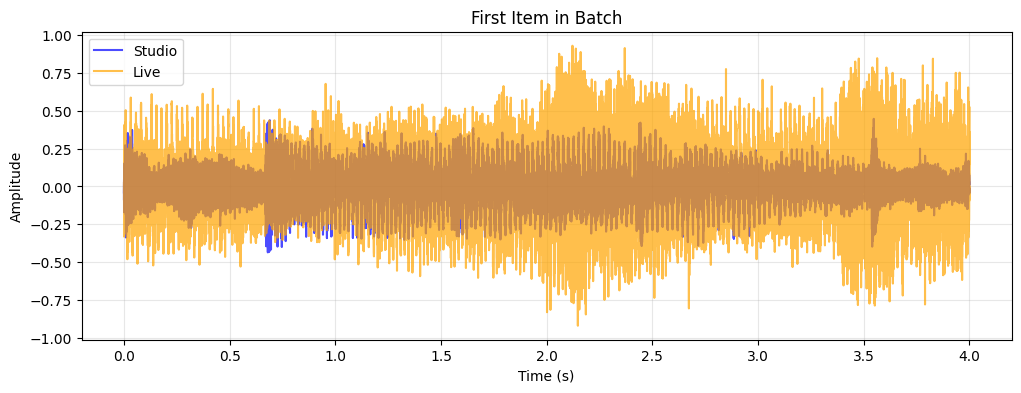

: 

In [ ]:
train_loader = dm.train_dataloader()
batch_x, batch_y = next(iter(train_loader))

print(f"Batch shape:")
print(f"  Studio (x): {batch_x.shape}")
print(f"  Live (y): {batch_y.shape}")

plt.figure(figsize=(12, 4))
time = np.arange(batch_x.shape[1]) / sr
plt.plot(time, batch_x[0].numpy(), alpha=0.7, label='Studio', color='blue')
plt.plot(time, batch_y[0].numpy(), alpha=0.7, label='Live', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('First Item in Batch')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()